In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [3]:

# defining the size of the image
SIZE = 160
color_img = []
path = '/content/drive/MyDrive/Lecture/LAB/DAY 2/Image colorization/colorized'
files = os.listdir(path)
for i in tqdm(files):
  img = cv2.imread(path + '/'+i,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (SIZE, SIZE))
  img = img.astype('float32') / 255.0
  color_img.append(img_to_array(img))
  


100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


In [4]:
print(files)

['11.png', '3.png', '7.png', '9.png', '13.png', '1.png', '2.png', '0.png', '4.png', '5.png', '10.png', '12.png', '8.png', '6.png']


In [5]:
gray_img = []
path = '/content/drive/MyDrive/Lecture/LAB/DAY 2/Image colorization/bnw'
#files = sorted_alphanumeric(files)
for i in tqdm(files):
  img = cv2.imread(path + '/'+i[:-3]+"jpg",1)
  img = cv2.resize(img, (SIZE, SIZE))
  img = img.astype('float32') / 255.0
  gray_img.append(img_to_array(img))

100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


In [9]:
print(files)

['11.png', '3.png', '7.png', '9.png', '13.png', '1.png', '2.png', '0.png', '4.png', '5.png', '10.png', '12.png', '8.png', '6.png']


In [7]:
len(gray_img)

14

In [8]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

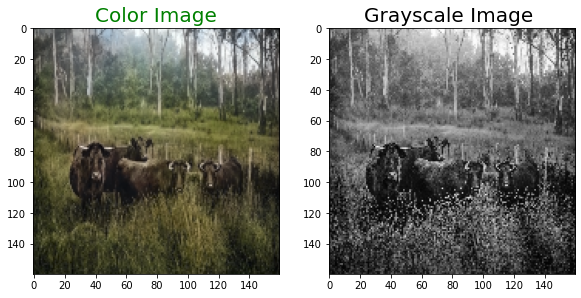

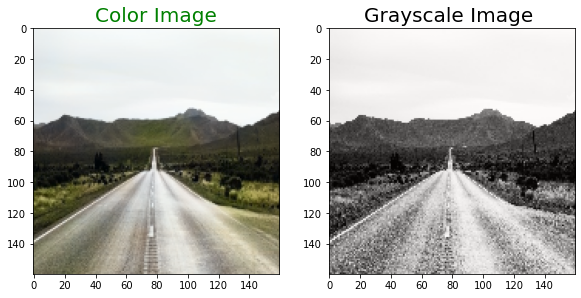

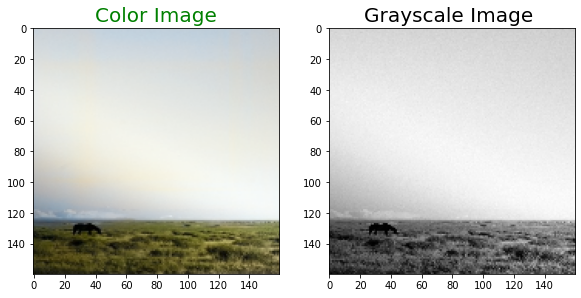

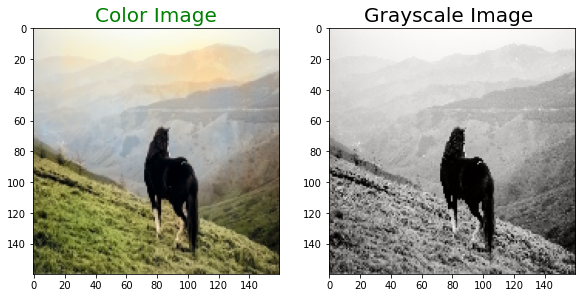

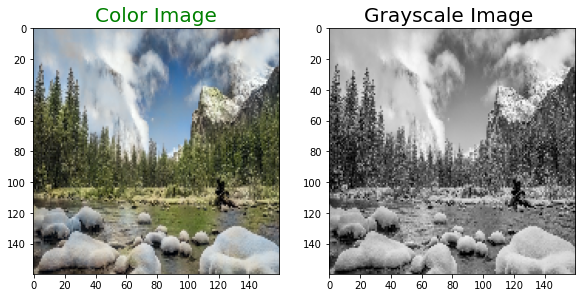

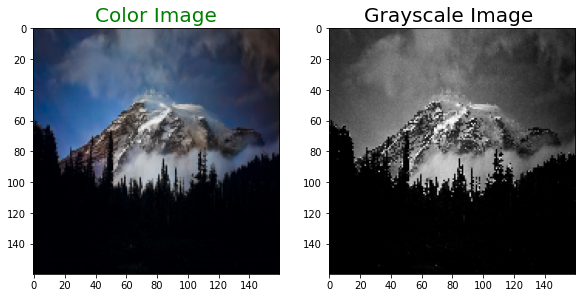

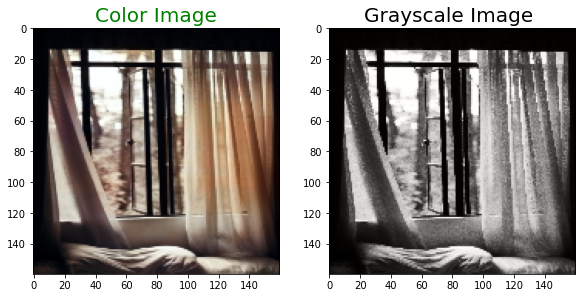

In [ ]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [ ]:
train_gray_image = gray_img[:10]
train_color_image = color_img[:10]

test_gray_image = gray_img[10:]
test_color_image = color_img[10:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (10, 160, 160, 3)
Test color image shape (4, 160, 160, 3)


In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)


In [ ]:
model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_30 (Sequential)     (None, 80, 80, 128)  3584        ['input_4[0][0]']                
                                                                                                  
 sequential_31 (Sequential)     (None, 40, 40, 128)  147584      ['sequential_30[0][0]']          
                                                                                                  
 sequential_32 (Sequential)     (None, 20, 20, 256)  296192      ['sequential_31[0][0]']    

In [ ]:

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.2711 - acc: 0.2967
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.2161 - acc: 0.3217
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.2097 - acc: 0.3195
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.1441 - acc: 0.3163
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.1165 - acc: 0.3004
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.0940 - acc: 0.3132
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.0879 - acc: 0.3451
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 0.0817 - acc: 0.3519
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 0.0752 - acc: 0.3389
Epoch 10/50
1/1 [==============================] - 3s 3s/step - loss: 0.0694 - acc: 0.3194
Epoch 11/50
1/1 [==============================] - 3s 3s/step - loss: 0.0683 - acc: 0.3137
Epoch 12

In [ ]:
model.evaluate(test_gray_image,test_color_image)

1/1 [==============================] - 1s 651ms/step - loss: 0.0757 - acc: 0.3401


[0.07566846162080765, 0.340087890625]

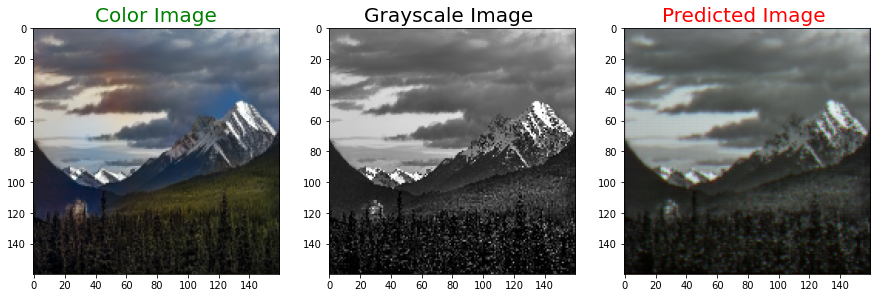

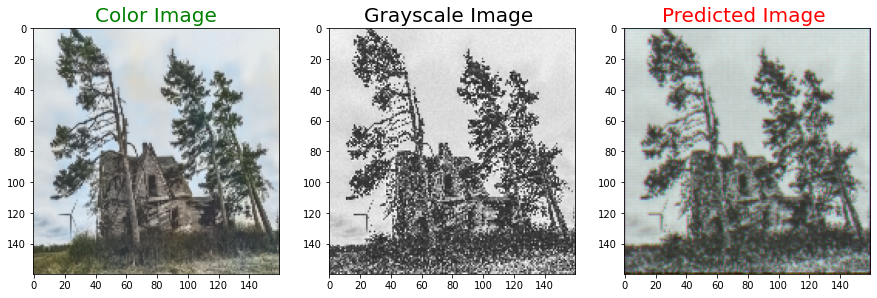

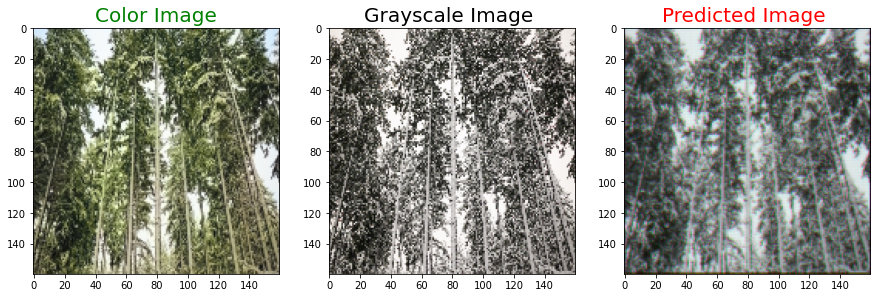

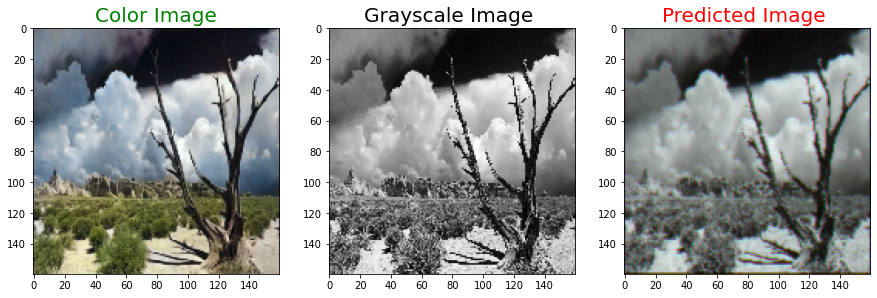

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(0,4):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)
